In [1]:
import math
import statistics
import random
import numpy as np

import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from tensorboardX import SummaryWriter

#from env import MancalaEnv
from game import Game
from randomagent import AgentRandom
from exactagent import AgentExact

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(14, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        y = self.relu(self.fc2(y))
        Q = self.fc3(y)

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()

In [4]:
#env = gym.make('CartPole-v0')
game = Game()
TEST_AGENT = AgentRandom()
#n_state = env.observation_space.shape[0]
n_state = 14
#n_action = env.action_space.n
n_action = 6
onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 4096
BATCH = 1000

num_episodes = 1000

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
writer = SummaryWriter('logs/dqn')
begin_learn = False

episode_reward = 0
wins = []
winsarray = np.zeros(shape = (num_episodes,3))
losses = []
for epoch in tqdm(range(num_episodes)):

    game = Game()
    #state = env.reset()
    state = game.board()
    episode_reward = 0
    done = False
    num_steps = 0
    while not done:
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1)
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)
        #next_state, reward, done, _ = env.step(action)
        score_dqn = np.asarray(game.move(action))
        next_state = game.board()
        if not done:
            game._player_one = False
            score_agent = score_dqn = np.asarray(game.move(TEST_AGENT._move(game)))
            game._player_one = True
            done = game.over()
        
        if done:
            # IF DQN LOST
            if score_dqn[0] < score_dqn[1]:
                reward = -1
                winsarray[epoch,:] = [epoch, num_steps, 0]
            else:
                reward = 1
                #wins.append((epoch,1))
                winsarray[epoch,:] = [epoch, num_steps, 1]
        else:
            reward = 0
        
        num_steps += 1
        
        episode_reward += reward
        memory_replay.add((state, next_state, action, reward, done))
        if memory_replay.size() > 128:
            if begin_learn is False:
                print('\nlearn begin!')
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                targetQ_next = targetQNetwork(batch_next_state)
                y = batch_reward + (1 - batch_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0]

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            writer.add_scalar('loss', loss.item(), global_step=learn_steps)

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        if done:
            break
        state = next_state

  0%|          | 0/1000 [00:00<?, ?it/s]
learn begin!
100%|██████████| 1000/1000 [06:13<00:00,  2.68it/s]


In [7]:
print(np.mean(winsarray[:,2]))

0.309


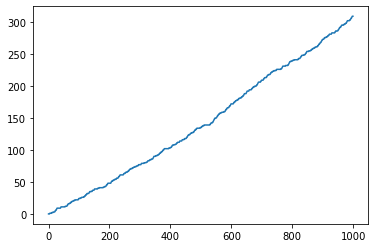

In [11]:
plt.plot(winsarray[:,0],np.cumsum(winsarray[:,2]))
plt.show()